In [1]:
import pandas as pd
import os
from os import path
import torch
from torch import nn
from torchvision import transforms, models
import PIL
from tqdm.auto import tqdm
import numpy as np
import pickle
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import random

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
def get_num_classes(df):
    return len(df.groupby("landmark_id"))

# Load csv and remove classes with no more than 3 instances

In [4]:
tqdm.pandas(desc="")

df_train = pd.read_csv('/cvhci/data/praktikumSS2019/gruppe1/google-landmark/train.csv')
print("read")
df_train = df_train.assign(
        path=lambda x: "/cvhci/data/praktikumSS2019/gruppe1/google-landmark/train/"
        + x.id
        + ".jpg"
    )

read


In [5]:
len(df_train)

4132914

In [6]:
df_train = df_train.groupby("landmark_id").filter(lambda x: len(x) > 3)
len(df_train)

4031134

In [7]:
isfile_mask = df_train.path.progress_apply(lambda x: path.isfile(x) and path.getsize(x) > 0)

In [8]:
df_train = df_train[isfile_mask]
len(df_train)

4028553

In [9]:
df_train.to_csv('/cvhci/data/praktikumSS2019/gruppe1/google-landmark/valid_train.csv', index=False)

In [17]:
df_train["path"].to_numpy()[0]

'/cvhci/data/praktikumSS2019/gruppe1/google-landmark/train/6e158a47eb2ca3f6.jpg'

# Calculate cosine similarity

In [5]:
!python extract_feats.py

In [5]:
df_train = pd.read_csv('/cvhci/data/praktikumSS2019/gruppe1/google-landmark/valid_train.csv')
print("csv loaded")
feats = np.load('/cvhci/data/praktikumSS2019/gruppe1/google-landmark/valid_train_places365_feats.npy')
print("feats loaded")

cvs loaded
feats loaded


In [19]:
# Normalize rows
feats = feats / np.linalg.norm(feats, axis=1, keepdims=True)

In [25]:
df_feats = pd.DataFrame(data=feats)

In [28]:
df_feats["landmark_id"] = df_train["landmark_id"]

In [43]:
dists = {x: (pdist(feats[v], np.dot), v) for x, v in tqdm(df_feats.groupby("landmark_id").groups.items())}

In [50]:
groups = df_feats.groupby("landmark_id").groups
dists = {x: (v, groups[x]) for x, v in tqdm(dists.items())}

In [54]:
with open('/cvhci/data/praktikumSS2019/gruppe1/google-landmark/valid_train_dists.pkl', 'wb') as f:
    pickle.dump(dists, f, pickle.HIGHEST_PROTOCOL)

# Filter pairs with cosine similarity below 0.85

In [4]:
df_train = pd.read_csv('/cvhci/data/praktikumSS2019/gruppe1/google-landmark/valid_train.csv')
with open('/cvhci/data/praktikumSS2019/gruppe1/google-landmark/valid_train_dists.pkl', 'rb') as f:
    dists = pickle.load(f)

In [5]:
def get_pairs(distv, indices, threshold):
    distm = squareform(distv)
    valid_entries = np.argwhere(distm > threshold)
    if len(valid_entries) == 0:
        return []
    ids = [(indices[a], indices[b]) for a, b in np.split(valid_entries, 2)[0]]
    return random.sample(ids, 100) if len(ids) > 100 else ids

def display_images(images):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = PIL.Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    display(new_im)

In [6]:
pairs = {x: get_pairs(v[0], v[1], 0.85) for x, v in tqdm(dists.items())}

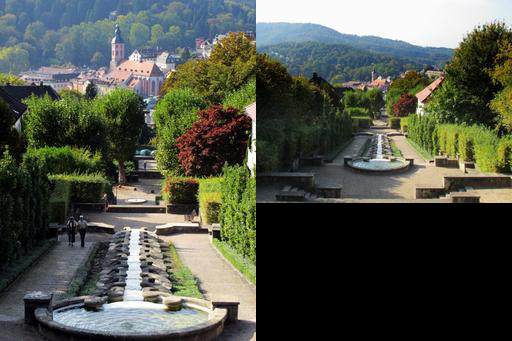

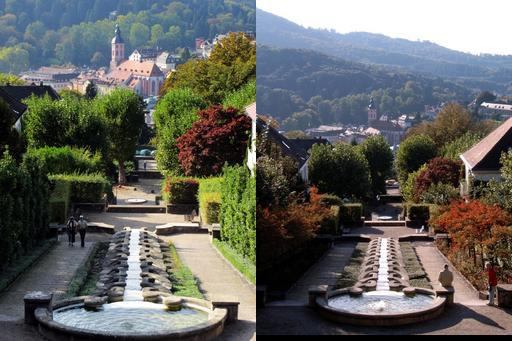

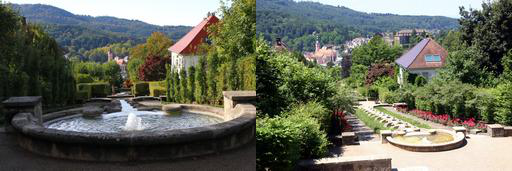

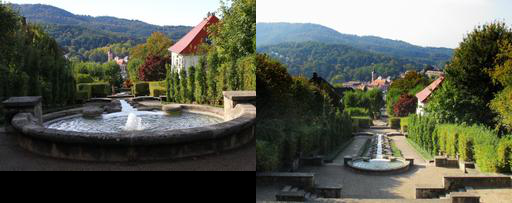

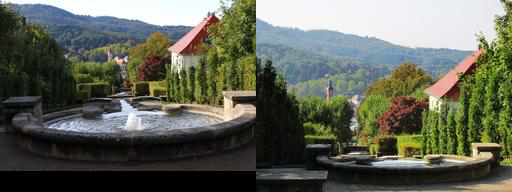

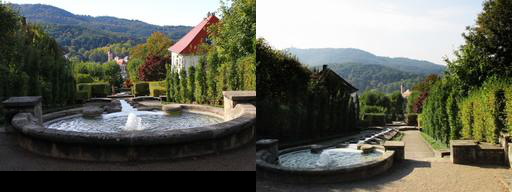

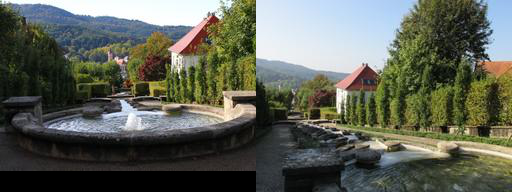

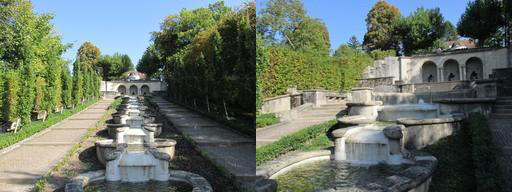

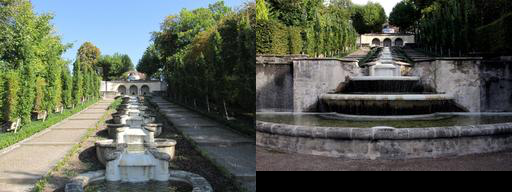

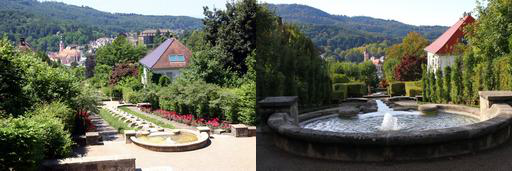

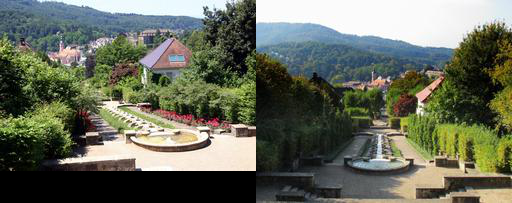

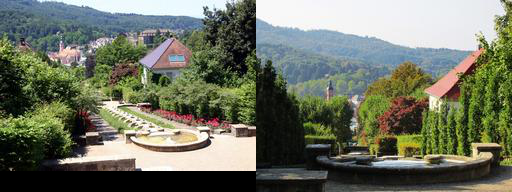

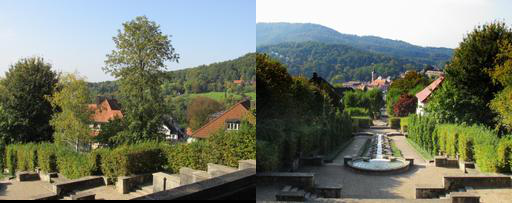

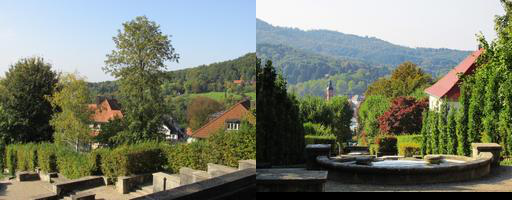

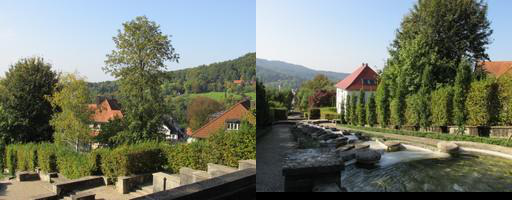

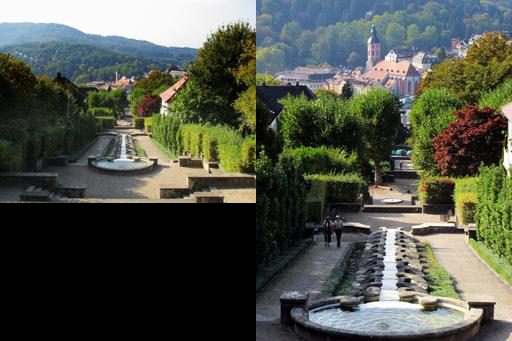

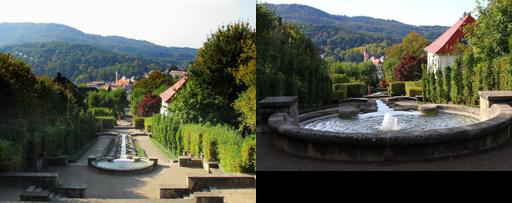

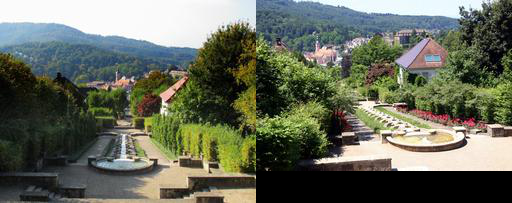

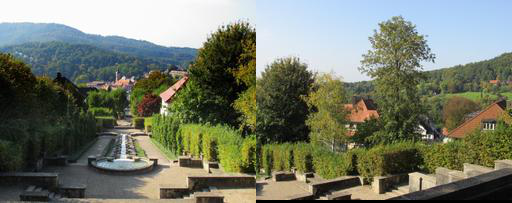

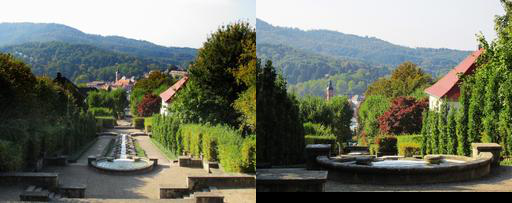

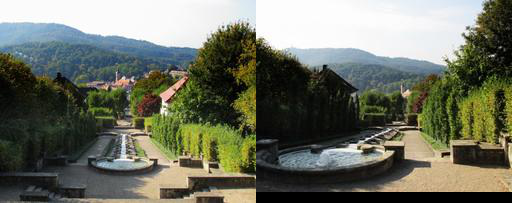

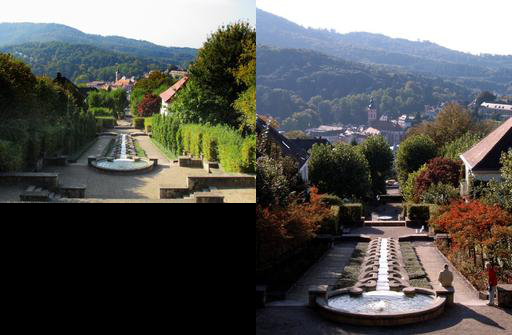

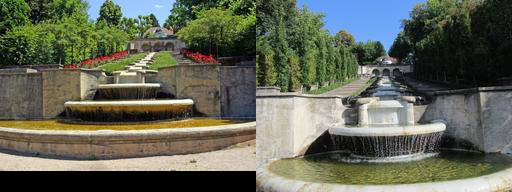

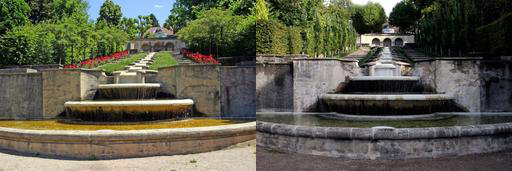

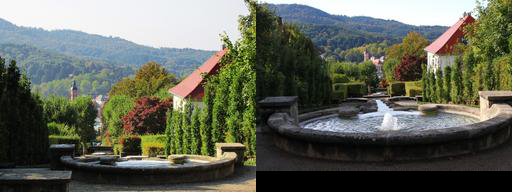

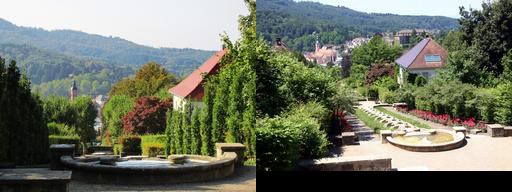

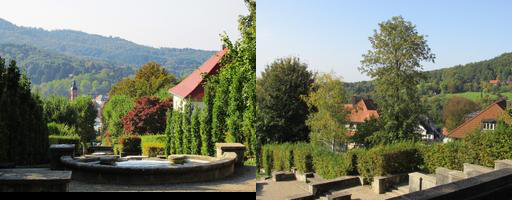

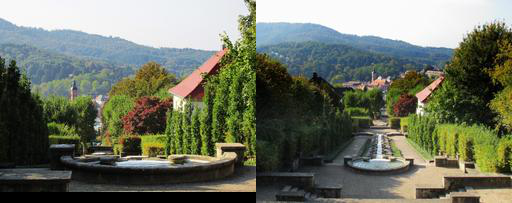

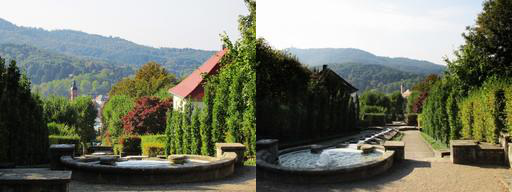

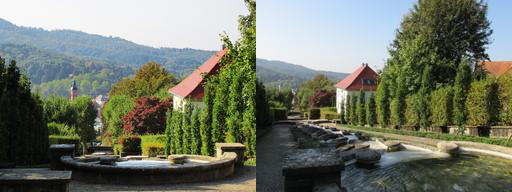

In [7]:
c = 12
for i in range(30):
    im1, im2 = PIL.Image.open(df_train.iloc[pairs[c][i][0]]["path"]), PIL.Image.open(df_train.iloc[pairs[c][i][1]]["path"])
    display_images([im1, im2])

In [8]:
sum([len(v) for x, v in pairs.items()])

3480107

In [9]:
sum([len(v)> 0 for x, v in pairs.items()])

133651

In [10]:
3480107/133651

26.03876514204907

In [106]:
with open('/cvhci/data/praktikumSS2019/gruppe1/google-landmark/valid_train_pairs.pkl', 'wb') as f:
    pickle.dump(pairs, f, pickle.HIGHEST_PROTOCOL)